## In this tutorial, I will show how to code a license plate recognizer for Indian license plates using deep learning and some image processing.
### Find the detailed explanation of the project in this blog: https://towardsdatascience.com/ai-based-indian-license-plate-detector-de9d48ca8951?source=friends_link&sk=a2cbd70e630f6dc3d030e3bae34d98ef

In [1]:
#  ! pip install imutils -q

import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

In [4]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('../input/ai-indian-license-plate-recognition-data/indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [27]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    print(plate_rect)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

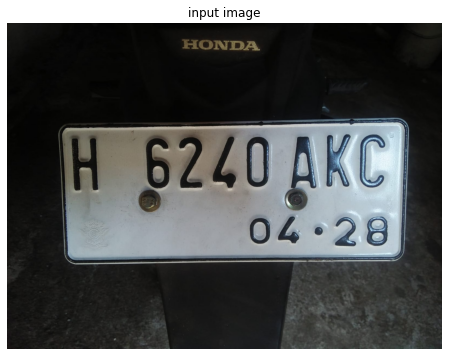

In [11]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
# req = urllib.request.urlopen('https://assets-a1.kompasiana.com/statics/crawl/557836cb0423bd875a8b4567.jpeg')
# req = urllib.request.urlopen('https://imgx.motorplus-online.com/crop/0x0:0x0/360x240/photo/2019/02/06/3813448616.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

aspect ratio from index: 0, 2.44, w: 1281, h: 525
detected plat no: 1


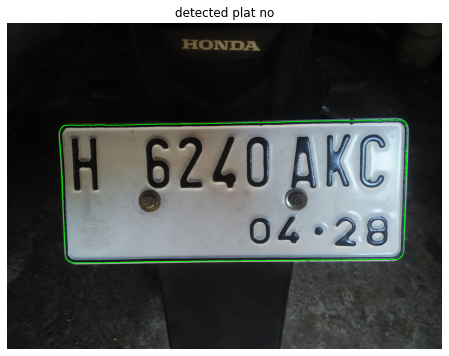

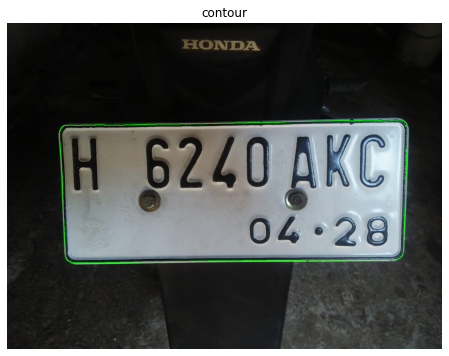

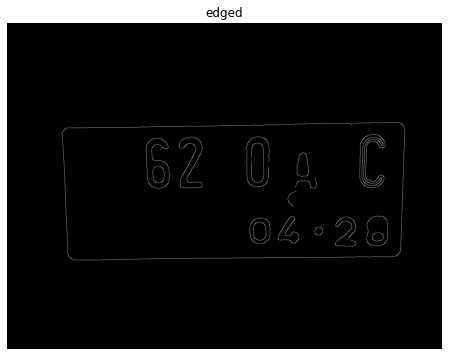

In [69]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (17,17), 0) 
edged   = cv2.Canny(blured, 10, 200)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(20,20))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)

platno=[]
index=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
    if w > 500 and h>200 and aspect_ratio <= 4 : 
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) == 1:
    indexplatno = platno[0]
    detectedimg = img.copy()
    cv2.drawContours(detectedimg, contours, indexplatno, (0, 255, 0), 2)

display(detectedimg, "detected plat no")
display(image_copy, "contour")
display(edged, "edged")

In [6]:
grayimg = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

blured = cv2.GaussianBlur(img.copy(), (21,21), 0)

lowerWhite = np.array([160, 200, 150])
upperWhite = np.array([255, 255, 255])
mask = cv2.inRange(blured.copy(), lowerWhite, upperWhite)

contours = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
cimg = cv2.drawContours(img.copy(), contours, 10, (0,255,0), 3)

for cnt in contours:
    sqaure_approx = cv2.approxPolyDP(cnt, 20, True)
    if len(sqaure_approx) == 4:
        plate_location = sqaure_approx


display (cimg)
display (mask)
display (blured)

# edged = cv2.Canny(blured, 75, 120)

# ret, thresh = cv2.threshold(edged, 127, 255, 0)
# contour, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# key_points=cv2.findContours(edged,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
# #defining contours from keypoints
# contours = imutils.grab_contours(key_points)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)


print(plate_location)

x1, x2 = min(plate_location[:,0][:,1]), max(plate_location[:,0][:,1])
y1, y2 = min(plate_location[:,0][:,0]), max(plate_location[:,0][:,0])
cropped_image = img[x1:x2, y1:y2]

display(cropped_image)

# display(cropped_image)
# display(edged)


error: OpenCV(4.3.0) /io/opencv/modules/imgproc/src/drawing.cpp:2469: error: (-215:Assertion failed) 0 <= contourIdx && contourIdx < (int)last in function 'drawContours'


()


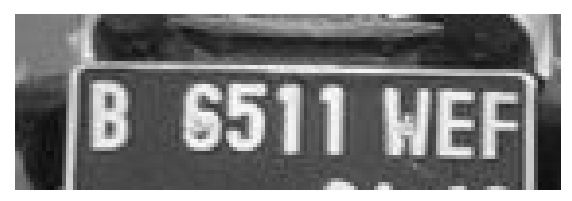

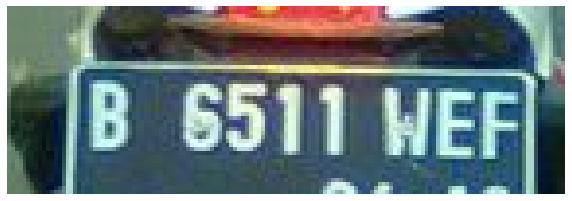

In [19]:
# req = urllib.request.urlopen('https://imgx.motorplus-online.com/crop/0x0:0x0/360x240/photo/2019/02/06/3813448616.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'

faceCascade = cv2.CascadeClassifier('/kaggle/input/haarcascadeplatenumber/haarcascade_russian_plate_number.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors = 5, minSize=(25,25))

for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    plate = gray[y: y+h, x:x+w]
    # plate = cv2.blur(plate,ksize=(20,20))
    # put the blurred plate into the original image
    crop = img[y: y+h, x:x+w]
    
print(faces)
display(plate)
display(crop)

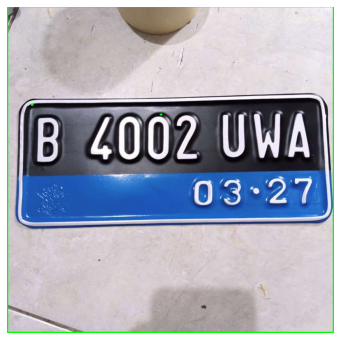

In [11]:
contours1, hierarchy1 = cv2.findContours(image=grayimg, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_contour_blue = img.copy()
cv2.drawContours(image=image_contour_blue, contours=contours1, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
display(image_contour_blue)

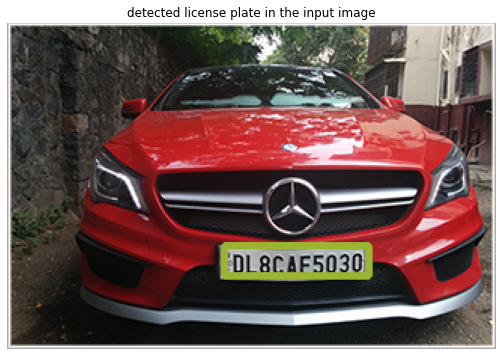

In [12]:
display(output_img, 'detected license plate in the input image')

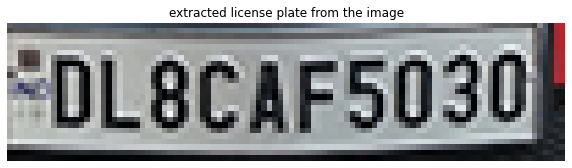

In [7]:
display(plate, 'extracted license plate from the image')

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
# Let's see the segmented characters
char = segment_characters(plate)

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [ ]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '../input/ai-indian-license-plate-recognition-data/data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

In [ ]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
plate_number = show_results()
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')